In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import models
import utils
import glob
import visualize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

c:\users\fanhangming\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Preprocess the image, linear normalize to -1~1, post_process turn it back to 0~1

In [37]:
def pre_process(img):
    return img * 2 - 1

def post_process(img):
    return (img + 1) / 2


#### Load MNIST dataset and show example images, choose ```batch_size```

In [38]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./dataset/MNIST_data', one_hot=True)

batch_size = 128

Extracting ./dataset/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./dataset/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data\t10k-labels-idx1-ubyte.gz


#### Function to create noisely initionalization of the generator in shape[batch_size, noise_dim]

In [4]:
def sample_noise(batch_size, dim):
    return np.random.uniform(-1, 1, size=(batch_size, dim))

#### Function to run a GAN, every n_critic times to train discriminator, train generator once

In [5]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10, n_critic=5):
    
    max_iter = mnist.train.num_examples*num_epoch // (batch_size * n_critic)
    for it in range(max_iter):
        if it % show_every == 0:
            noise_z = sample_noise(batch_size, noise_dim)
            samples = sess.run(G_sample, feed_dict={z:noise_z})
            fig = visualize.show_images(samples[:16])
            plt.show()
            print()
        
        for i in range(n_critic):
            noise_z = sample_noise(batch_size, noise_dim)
            minibatch = np.reshape(mnist.train.next_batch(batch_size)[0], [-1, 28, 28, 1])
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x:pre_process(minibatch), z:noise_z})
        
        
        noise_z = sample_noise(batch_size, noise_dim)            
        _, G_loss_curr = sess.run([G_train_step, G_loss,], feed_dict={z:noise_z})
        
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it, max_iter,D_loss_curr, G_loss_curr))
    print('Final images')
    noise_z = sample_noise(100, noise_dim)
    samples = sess.run(G_sample, feed_dict={z:noise_z})
    
    fig = visualize.show_images(samples, final="./images/DCGAN_231")
    plt.show()

### Get the generator and discriminator model and create the input

In [6]:
tf.reset_default_graph()

noise_dim = 96

x = tf.placeholder(tf.float32, [None, 28, 28, 1])
z = tf.placeholder(tf.float32, [None, noise_dim])
generator = models.generator_231
discriminator = models.discriminator_WGAN_231

G_sample = generator(z, reuse=False)
logits_real = discriminator(x, reuse=False)
logits_fake = discriminator(G_sample)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

## WGAN-PG loss
##### WGAN-GP
- batch_size = 64
- noise_dim = 100
- n_critic = 3
- leaning_rate = 1e-3

In [7]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    
    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
    G_loss = -tf.reduce_mean(logits_fake)
    
    lam = 10
    shape = tf.concat((tf.shape(x)[0:1], tf.tile([1], [x.shape.ndims - 1])), axis=0)
    eps = tf.random_uniform(shape=shape, minval=0., maxval=1.)
    x_hat = x + eps * (G_sample - x)
   
    with tf.variable_scope('', reuse=True) as scope:
        pred = discriminator(x_hat)
        grad_D_x_hat = tf.gradients(pred, x)[0]
    
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=tf.range(1, x.shape.ndims)))
    grad_pen = lam * tf.reduce_mean((grad_norm - 1.) ** 2)
    
    D_loss += grad_pen
    
    return D_loss, G_loss

D_loss, G_loss  =wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample)
# var_list: 起到训练G/D时只更新G/D参数的作用
D_train_step = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5).minimize(D_loss, var_list=D_vars)
G_train_step = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5).minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

## Train part

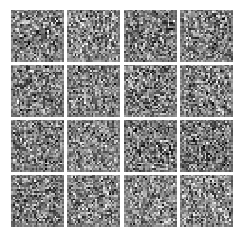


Iter: 0/4296, D: 1.384, G:0.6682
Iter: 50/4296, D: 0.7029, G:4.394
Iter: 100/4296, D: 0.9487, G:1.247
Iter: 150/4296, D: 1.267, G:0.4854
Iter: 200/4296, D: 1.227, G:0.9356


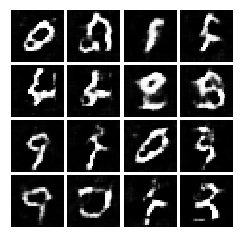


Iter: 250/4296, D: 1.333, G:0.9733
Iter: 300/4296, D: 1.227, G:0.7628
Iter: 350/4296, D: 1.183, G:0.8006
Iter: 400/4296, D: 1.162, G:0.924
Iter: 450/4296, D: 1.243, G:0.9699


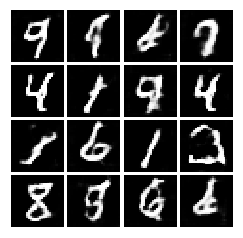


Iter: 500/4296, D: 1.267, G:0.9782
Iter: 550/4296, D: 1.18, G:0.9382
Iter: 600/4296, D: 1.203, G:0.6779
Iter: 650/4296, D: 1.22, G:0.8583
Iter: 700/4296, D: 1.188, G:0.7979


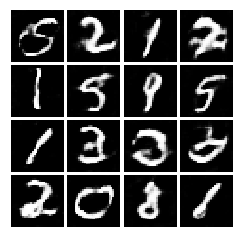


Iter: 750/4296, D: 1.659, G:2.358
Iter: 800/4296, D: 1.291, G:1.156
Iter: 850/4296, D: 1.179, G:0.9474
Iter: 900/4296, D: 1.245, G:1.265
Iter: 950/4296, D: 1.194, G:0.889


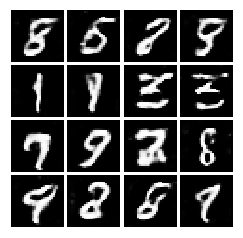


Iter: 1000/4296, D: 1.177, G:1.245
Iter: 1050/4296, D: 1.109, G:1.043
Iter: 1100/4296, D: 1.395, G:0.4813
Iter: 1150/4296, D: 1.299, G:0.663
Iter: 1200/4296, D: 1.143, G:1.045


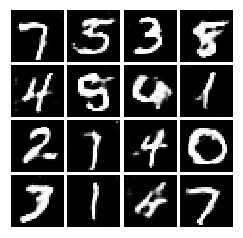


Iter: 1250/4296, D: 1.113, G:1.24
Iter: 1300/4296, D: 1.043, G:1.353
Iter: 1350/4296, D: 1.13, G:0.9825
Iter: 1400/4296, D: 1.045, G:0.9639
Iter: 1450/4296, D: 1.024, G:0.9893


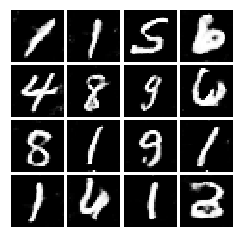


Iter: 1500/4296, D: 1.031, G:1.041
Iter: 1550/4296, D: 1.097, G:1.965
Iter: 1600/4296, D: 0.9843, G:1.217
Iter: 1650/4296, D: 1.03, G:0.6016
Iter: 1700/4296, D: 1.311, G:2.061


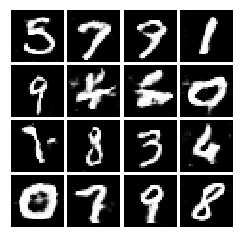


Iter: 1750/4296, D: 1.054, G:1.935
Iter: 1800/4296, D: 0.9366, G:1.064
Iter: 1850/4296, D: 1.063, G:0.9498
Iter: 1900/4296, D: 1.45, G:2.15
Iter: 1950/4296, D: 0.9141, G:1.302


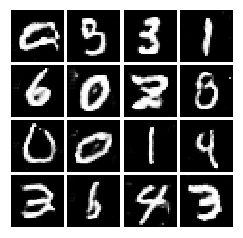


Iter: 2000/4296, D: 0.9777, G:2.256
Iter: 2050/4296, D: 1.9, G:2.843
Iter: 2100/4296, D: 0.9402, G:1.29
Iter: 2150/4296, D: 1.166, G:2.692
Iter: 2200/4296, D: 0.8287, G:1.546


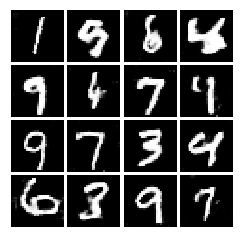


Iter: 2250/4296, D: 1.175, G:2.103
Iter: 2300/4296, D: 1.185, G:2.308
Iter: 2350/4296, D: 0.9207, G:0.9881
Iter: 2400/4296, D: 0.8565, G:1.189
Iter: 2450/4296, D: 0.8535, G:0.7578


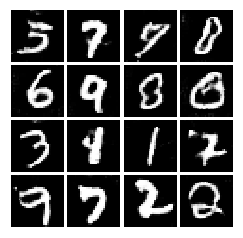


Iter: 2500/4296, D: 1.19, G:0.5585
Iter: 2550/4296, D: 0.7917, G:1.227
Iter: 2600/4296, D: 1.283, G:3.106
Iter: 2650/4296, D: 0.8994, G:1.419
Iter: 2700/4296, D: 0.7158, G:2.25


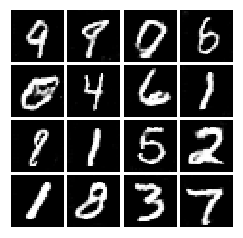


Iter: 2750/4296, D: 0.7472, G:2.213
Iter: 2800/4296, D: 0.8299, G:1.348
Iter: 2850/4296, D: 0.7819, G:1.717
Iter: 2900/4296, D: 0.7369, G:1.735
Iter: 2950/4296, D: 0.7721, G:1.287


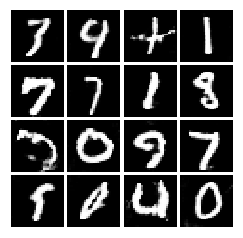


Iter: 3000/4296, D: 0.7554, G:1.664
Iter: 3050/4296, D: 1.099, G:0.6908
Iter: 3100/4296, D: 0.7891, G:0.9134
Iter: 3150/4296, D: 0.9573, G:2.335
Iter: 3200/4296, D: 1.076, G:3.664


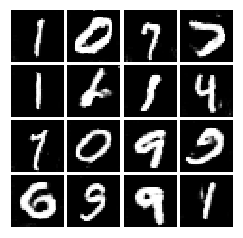


Iter: 3250/4296, D: 0.7251, G:1.9
Iter: 3300/4296, D: 0.8144, G:1.031
Iter: 3350/4296, D: 0.9677, G:1.245
Iter: 3400/4296, D: 1.166, G:1.122
Iter: 3450/4296, D: 1.092, G:1.015


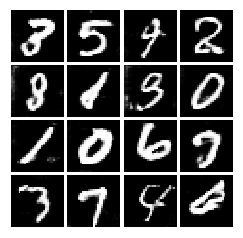


Iter: 3500/4296, D: 1.109, G:1.047
Iter: 3550/4296, D: 0.9306, G:1.056
Iter: 3600/4296, D: 0.8652, G:1.076
Iter: 3650/4296, D: 0.9777, G:0.7216
Iter: 3700/4296, D: 0.8018, G:0.8883


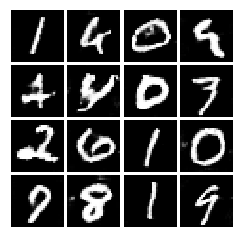


Iter: 3750/4296, D: 0.7444, G:1.357
Iter: 3800/4296, D: 0.9209, G:1.923
Iter: 3850/4296, D: 0.92, G:0.7936
Iter: 3900/4296, D: 0.7409, G:1.895
Iter: 3950/4296, D: 0.7887, G:2.116


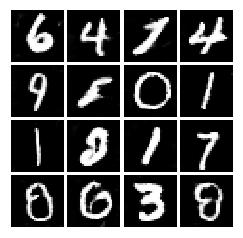


Iter: 4000/4296, D: 0.7185, G:2.01
Iter: 4050/4296, D: 0.7116, G:2.311
Iter: 4100/4296, D: 0.5947, G:2.232
Iter: 4150/4296, D: 0.8327, G:0.7098
Iter: 4200/4296, D: 0.9219, G:0.837


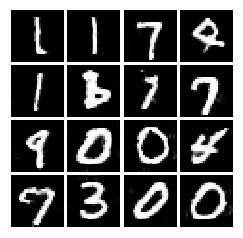


Iter: 4250/4296, D: 0.7051, G:2.031
Final images


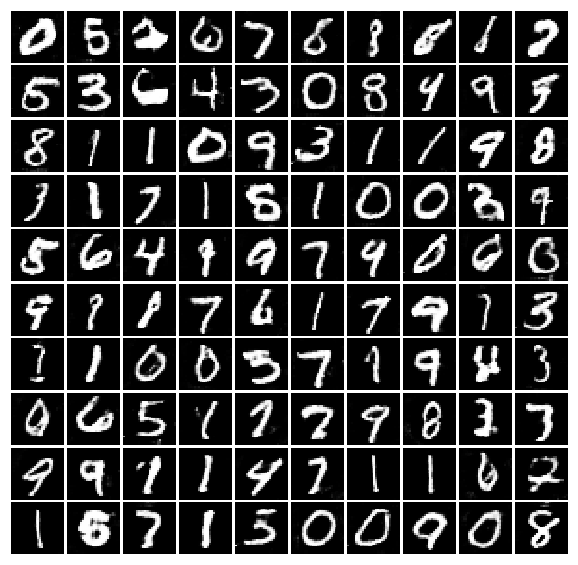

In [8]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, batch_size=batch_size, num_epoch=10, n_critic=1)